In [1]:
from nilearn import datasets
#dir='/raid/nilearn_data'
adhd_dataset = datasets.fetch_adhd(n_subjects=10)
func_filenames = adhd_dataset.func  # list of 4D nifti files for each subject

# print basic information on the dataset
print('First functional nifti image (4D) is at: %s' %
      func_filenames[0])  # 4D data

from nilearn.decomposition import CanICA

canica = CanICA(smoothing_fwhm=6.,
                memory="nilearn_cache", memory_level=2,
                threshold=3., verbose=10, random_state=0)
x_train=canica.prepare_data(func_filenames)


/home/uga_qinglin/Documents/nilearn-deep/nilearn/datasets/func.py:503: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  dtype=None)


First functional nifti image (4D) is at: /home/uga_qinglin/nilearn_data/adhd/data/0010042/0010042_rest_tshift_RPI_voreg_mni.nii.gz
[MultiNiftiMasker.fit] Loading data from [/home/uga_qinglin/nilearn_data/adhd/data/0010042/0010042_rest_tshift_RPI_voreg_mni.nii.gz, /home/uga_qinglin/nilearn_data/adhd/data/0010064/0010064_rest_tshift_RPI_voreg_mni.nii.gz, /home/uga_qinglin
[MultiNiftiMasker.fit] Computing mask
[MultiNiftiMasker.transform] Resampling mask
[CanICA] Loading data
/home/uga_qinglin/nilearn_data/adhd/data/0010042/0010042_rest_tshift_RPI_voreg_mni.nii.gz
/home/uga_qinglin/nilearn_data/adhd/data/0010064/0010064_rest_tshift_RPI_voreg_mni.nii.gz
/home/uga_qinglin/nilearn_data/adhd/data/0010128/0010128_rest_tshift_RPI_voreg_mni.nii.gz
/home/uga_qinglin/nilearn_data/adhd/data/0021019/0021019_rest_tshift_RPI_voreg_mni.nii.gz
/home/uga_qinglin/nilearn_data/adhd/data/0023008/0023008_rest_tshift_RPI_voreg_mni.nii.gz
/home/uga_qinglin/nilearn_data/adhd/data/0023012/0023012_rest_tshift_RPI

In [2]:
'''This script demonstrates how to build a variational autoencoder with Keras.

 #Reference

 - Auto-Encoding Variational Bayes
   https://arxiv.org/abs/1312.6114
'''
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist

batch_size = 1
original_dim=x_train.shape[1]
latent_dim = 32
intermediate_dim = 500
epochs = 10
epsilon_std = 1.0


x = Input(shape=(original_dim,))
h = Dense(256, activation='tanh')(x)
h = Dense(128, activation='tanh')(h)
h = Dense(64, activation='tanh')(h)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)


def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# we instantiate these layers separately so as to reuse them later

h_decoded = Dense(64, activation='tanh')(z)
h_decoded = Dense(128, activation='tanh')(h_decoded)
h_decoded = Dense(256, activation='tanh')(h_decoded)
x_decoded_mean = Dense(original_dim, activation='sigmoid')(h_decoded)

# instantiate VAE model
vae = Model(x, x_decoded_mean)

# Compute VAE loss
xent_loss = original_dim * metrics.binary_crossentropy(x,x_decoded_mean )
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(xent_loss + kl_loss)

vae.add_loss(vae_loss)
from keras import optimizers
rmsprop=optimizers.RMSprop(lr=0.00001, rho=0.9, epsilon=None, decay=0.0)
vae.compile(optimizer=rmsprop)
vae.summary()


vae.fit(x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size)

encoder = Model(x, z_mean)



Using TensorFlow backend.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64992)        0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 256)          16638208    input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 128)          32896       dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 64)           8256        dense_2[0][0]                    
__________________________________________________________________________________________________
dense_4 (D

In [3]:
decoder=Model(x, z)
y=decoder.predict(x_train,
        batch_size=batch_size)
y.shape

(200, 32)

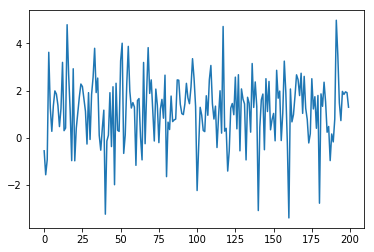

In [4]:

import numpy as np
t = range(0, 200)

import matplotlib.pyplot as plt
plt.plot(t, y[:,1])

In [5]:
from sklearn.linear_model import Lasso
clf = Lasso(alpha=0.1)
clf.fit(y,x_train)
print(clf.coef_.shape)

(64992, 32)


In [6]:
#W=decoder_mean.get_weights()
#components_img=W[0]


In [7]:
from nilearn.input_data import NiftiMasker
masker = NiftiMasker(mask_img=canica.masker_.mask_img_, standardize=True)
masker.fit()

import numpy as np
components_img = masker.inverse_transform(np.transpose(clf.coef_))

/usr/local/lib/python2.7/dist-packages/matplotlib/contour.py:946: UserWarning: linewidths is ignored by contourf
  warnings.warn('linewidths is ignored by contourf')
/usr/local/lib/python2.7/dist-packages/matplotlib/contour.py:1230: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


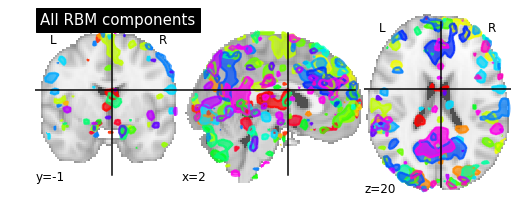

In [8]:
from nilearn import plotting

plotting.plot_prob_atlas(components_img, view_type='filled_contours',
                         title='All RBM components')

/usr/local/lib/python2.7/dist-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


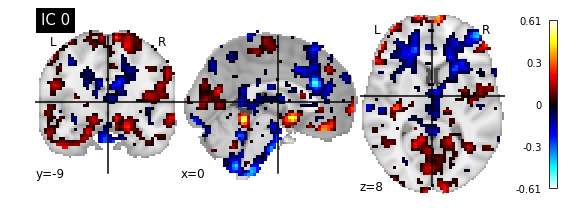

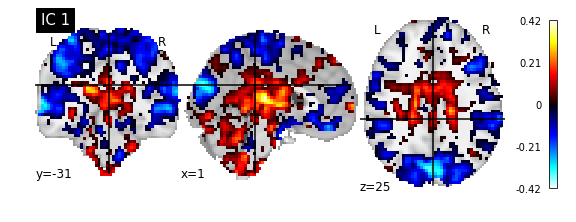

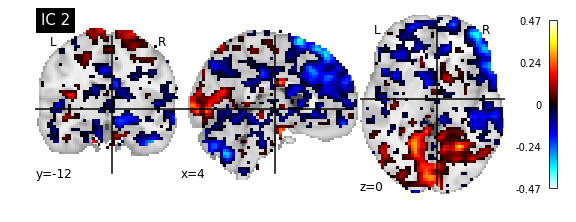

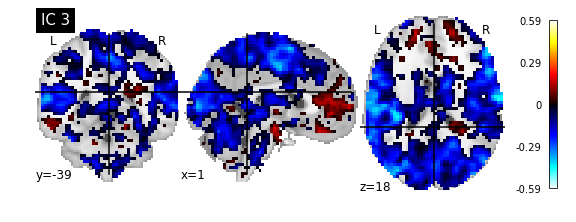

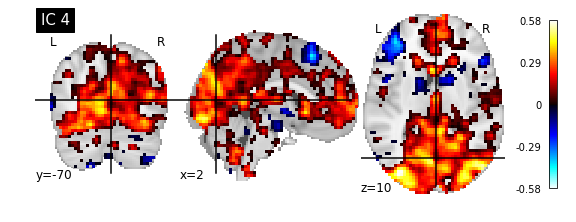

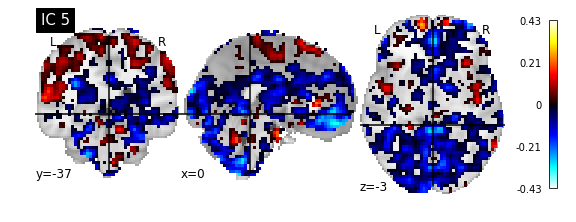

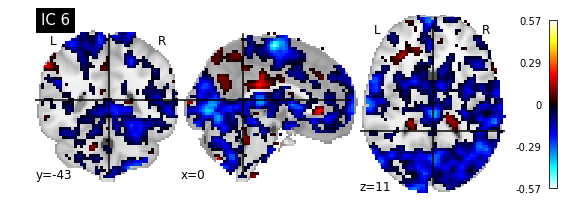

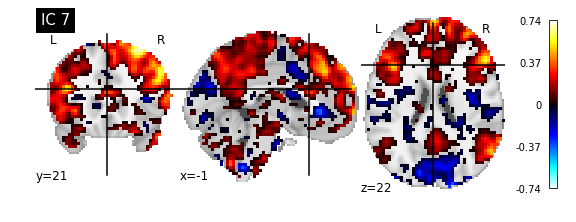

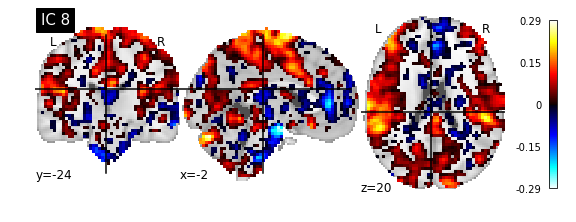

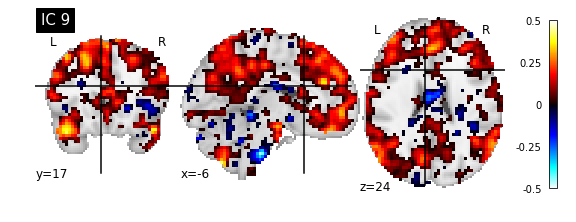

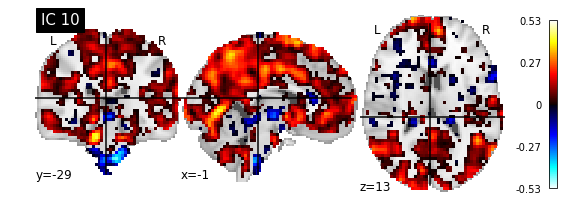

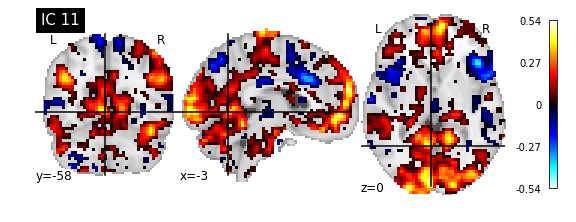

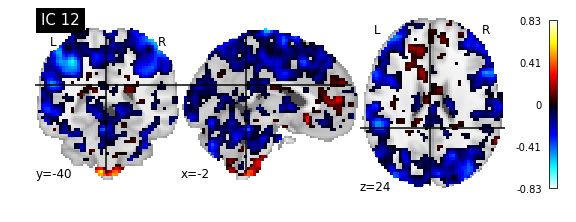

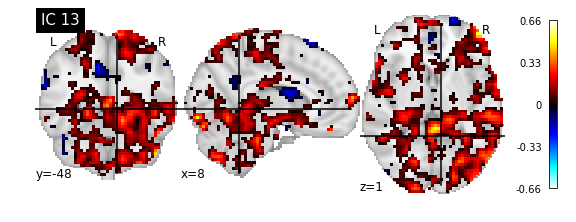

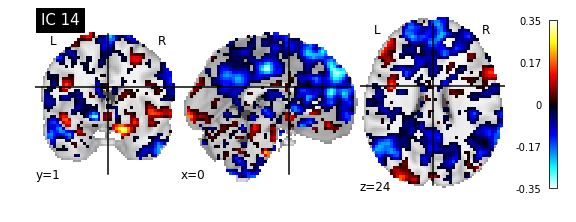

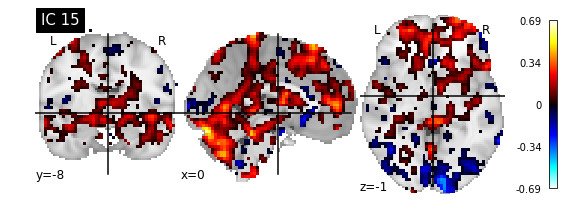

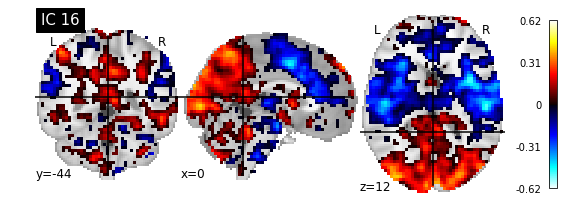

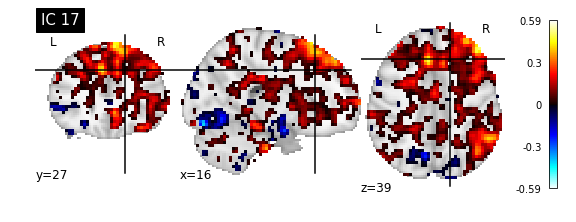

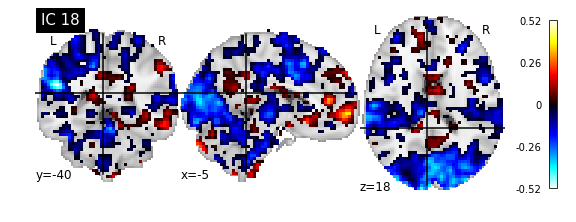

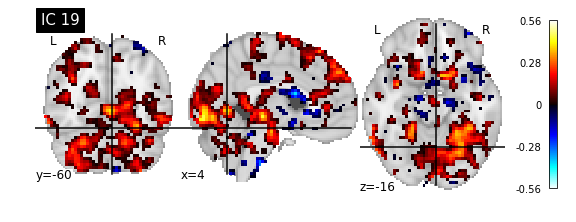

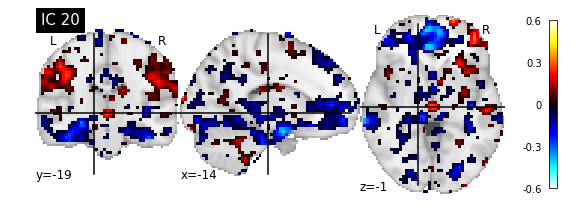

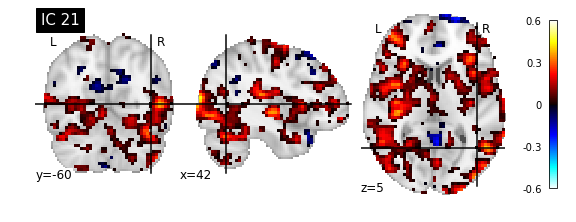

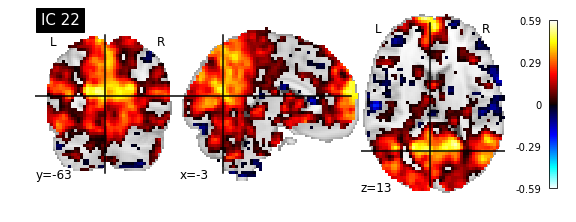

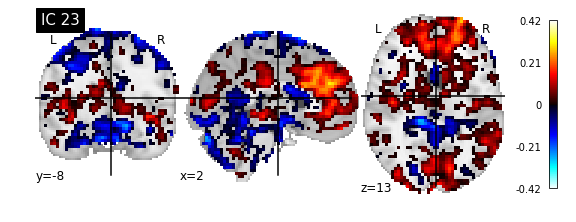

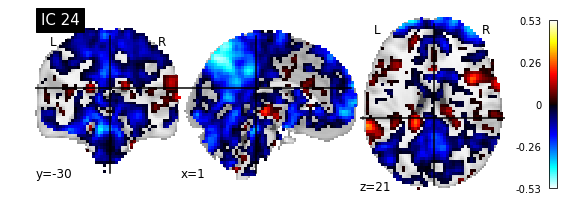

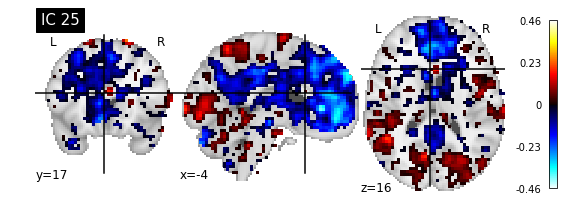

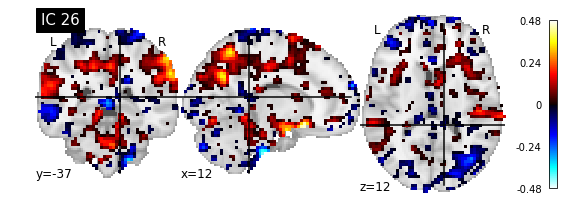

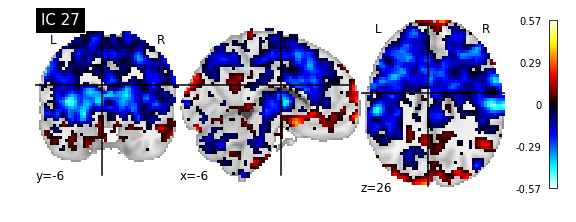

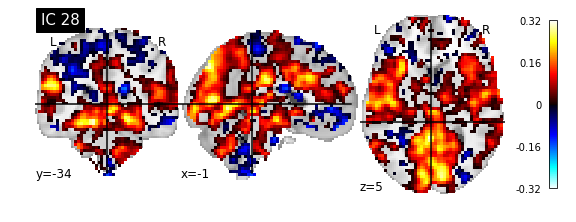

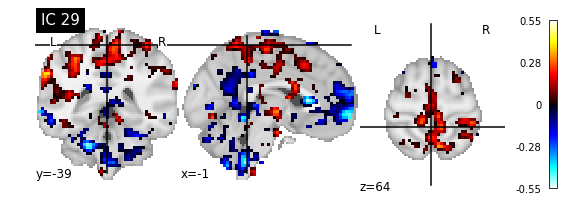

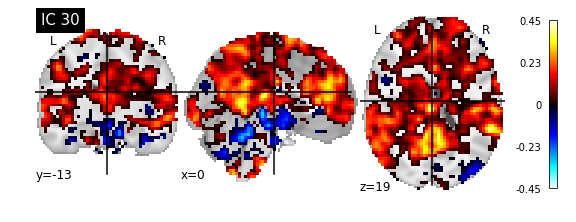

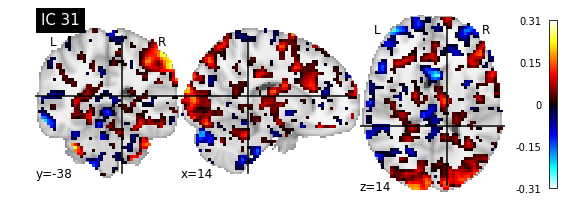

In [9]:
from nilearn.image import iter_img
from nilearn.plotting import plot_stat_map, show

for i, cur_img in enumerate(iter_img(components_img)):
    plot_stat_map(cur_img, display_mode="ortho", title="IC %d" % i,
                  cut_coords=None, colorbar='bwr')

show()